In [1]:
import numpy as np
from multiprocessing import Pool
from functools import partial
import plotly.graph_objects as go
import gzip
import pickle as pkl

import games
import synthetic_data
import random_algo


import cpb_side
import cpb_side_gaussian
import linucb


import PGIDSratio
import synthetic_data
import numpy as np
from torchvision import datasets, transforms


class FakeIds():

    def __init__(self, digit_distribution, imbalance):

        self.horizon = horizon
        self.imbalance = imbalance
        self.digit_distribution = digit_distribution
        self.M = np.array(  [ [ 0.91,0,0,0,0,0,0.03,0,0.03,0.03 ], 
                 [ 0,0.9,0,0,0.01,0,0,0.09,0,0 ],
                 [ 0,0,0.97,0.03,0,0,0,0,0,0 ],
                 [ 0,0,0,0.92,0,0,0,0,0.04,0.04 ],
                 [ 0,0,0,0,0.99,0,0,0,0.01,0 ],
                 [ 0,0,0,0,0,0.96,0.02,0,0.02,0 ],
                 [ 0.02,0,0,0,0,0,0.98,0,0,0 ],
                 [ 0.12,0,0,0,0,0,0,0.88,0,0 ],
                 [ 0,0,0,0,0,0,0,0,1,0 ],
                 [ 0,0,0,0,0,0,0,0,0,1 ] ] )

        # switches = { 0:[6, 8, 9], 1:[4, 7], 2:[3], 3:[8, 9], 4:[8], 5:[6, 8], 6:[8], 7:[1], 8:[], 9:[] }

        # self.M = np.array( [ [ 1,0,0,0,0,0,0,0,0,0 ], 
        #     [ 0,1,0,0,0,0,0,0,0,0 ],
        #     [ 0,0,1,0,0,0,0,0,0,0 ],
        #     [ 0,0,0,1,0,0,0,0,0,0 ],
        #     [ 0,0,0,0,1,0,0,0,0,0 ],
        #     [ 0,0,0,0,0,1,0,0,0,0 ],
        #     [ 0,0,0,0,0,0,1,0,0,0 ],
        #     [ 0,0,0,0,0,0,0,1,0,0 ],
        #     [ 0,0,0,0,0,0,0,0,1,0 ],
        #     [ 0,0,0,0,0,0,0,0,0,1 ] ] )

        
        
    def get_contexts(self, horizon, game):

        p_attack = game.outcome_dist['spam']

        contexts = np.empty( ( horizon, 10) )
        outcomes = np.zeros( horizon, dtype = int)

        for i in range(horizon):

            label = np.random.choice( [0,1,2,3,4,5,6,7,8,9] , p = self.imbalance)

            contexts[i] = np.zeros(10)
            pred_label = np.random.choice(  [0,1,2,3,4,5,6,7,8,9] , p = self.M[label] )
            contexts[i][pred_label] = 1
            
            if pred_label != label:
                outcomes[i] = 1
            else:
                outcomes[i] = 0

                
        return outcomes, contexts

# def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type):
#     print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
#     pool = Pool(processes = nbCores) 
#     task = Evaluation(horizon, type)

#     np.random.seed(1)
#     distributions = []
#     context_generators = []

#     for jobid in range(n_folds):
        
#         p = np.random.uniform(0, 0.2) if type == 'easy' else np.random.uniform(0.4,0.5)
#         distributions.append( [p, 1-p] )

#         contexts = FakeIds() #.LinearContexts( np.array([0.5,0.5]), 0, d, margin) #synthetic_data.ToyContexts( )
#         context_generators.append( contexts )

#     return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions , context_generators ,range(n_folds)) ) ) 

class Evaluation:

    def __init__(self, horizon, type ):
        self.type = type
        self.horizon = horizon

        # self.outcome_distribution = outcome_distribution

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def get_bandit_feedback(self, game, action, outcome):
        return game.banditFeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        distribution, context_generator, jobid = job

        np.random.seed(jobid)

        # outcome_distribution =  {'spam':0.5,'ham':0.5}
        outcome_distribution =  {'spam':distribution[0], 'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution, jobid )
        #print('optimal action', game.i_star)

        # action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously

        
        outcomes, contexts = context_generator.get_contexts(self.horizon, game) 
        # outcomes = self.get_outcomes(game, jobid)
        # contexts = context_generator.get_contexts( self.data, outcomes )
        # print(len(contexts))

        # 
        # contexts = [ context_generator.get_context(outcome) for outcome in outcomes ]
        # context_generator.generate_unique_context()
        # contexts = [ context_generator.get_same_context(outcome) for outcome in outcomes ]
        #print('theta', context_generator.w )

        cumRegret =  np.zeros(self.horizon, dtype =float)

        alg.reset()

        estimates_history = {}
        
        for t in range(self.horizon):

            if t % 1000 == 0 and t>0 :
                print(t)
                estimates = []
                for i in range(10):
                    context = np.zeros(10)
                    context[i] = 1
                    # context = context.reshape((-1,1))
                    estimate = alg.contexts[1]['weights'] @ context
                    estimates.append( estimate[0] )
                estimates_history[t] = estimates

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]
            context = contexts[t].reshape((-1,1))

            # policy chooses one action
            #print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t, context)

            # print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )
            bandit_feedback =  self.get_bandit_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )
            
            # print('nu', alg.nu / alg.n )
            regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )
            # print( 'regret:' , regret )
            cumRegret[t] =  regret
            # print()
        # regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter
        #context_regret = np.cumsum( 
        # cumRegret )

        return  np.cumsum( cumRegret ), estimates_history #regret


In [46]:
M = np.array(  [ [ 0.91,0,0,0,0,0,0.03,0,0.03,0.03 ], 
                 [ 0,0.9,0,0,0.01,0,0,0.09,0,0 ],
                 [ 0,0,0.97,0.03,0,0,0,0,0,0 ],
                 [ 0,0,0,0.92,0,0,0,0,0.04,0.04 ],
                 [ 0,0,0,0,0.99,0,0,0,0.01,0 ],
                 [ 0,0,0,0,0,0.96,0.02,0,0.02,0 ],
                 [ 0.02,0,0,0,0,0,0.98,0,0,0 ],
                 [ 0.12,0,0,0,0,0,0,0.88,0,0 ],
                 [ 0,0,0,0,0,0,0,0,1,0 ],
                 [ 0,0,0,0,0,0,0,0,0,1 ] ] )
        
np.sum(M,1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

1000
2000
3000
4000


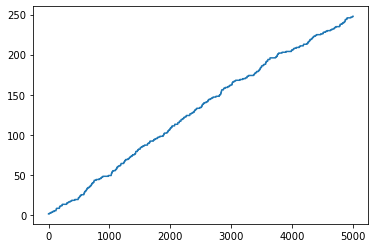

In [10]:
# # d = 784 #2
# # w = np.random.uniform(-1,1, d) #np.array([0.5,0.5])
# # margin = 0.01
# # contexts_generator = synthetic_data.LinearContexts( w, 0, d, margin) #synthetic_data.ToyContexts( )

#game =  games.apple_tasting( False ) 
# data = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor() )
# replacements = get_replacement_samples()
# sampling_indexes = np.random.randint(0, len(data), horizon)


n_cores = 1
n_folds = 1
horizon = 5000

game = games.apple_tasting(False)

alg = cpb_side_gaussian.RandCPB_side(game, 10, horizon, 1.01, 0.05, 1/8, 10, False, 10e-7)
# alg = cpb_side.CPB_side(  game, 2, horizon, 1.01, 0.001) 
# alg = linucb.LinUCB(game, horizon, 1.01) #
# alg = PGIDSratio.PGIDSratio( game, horizon, 2 )

task = Evaluation(horizon, 'easy')

outcome_distribution = [0.5, 0.5]

imbalance = np.ones(10)/10
# imbalance = np.array( [0.05,0.05,0.05, 0.1,0.1,0.1, 0.15,0.15,0.15,0.1] )

# digit_distribution =  np.array( [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] )
digit_distribution = [0.00938744, 0.02826442, 0.06660327, 0.12284535, 0.17736299, 0.2004605, 0.17736299, 0.12284535, 0.06660327, 0.02826442]
# digit_distribution = [3.03931336e-02, 1.21241604e-01, 1.92058772e-01, 1.21241604e-01, 3.03931336e-02, 2.99782587e-03, 1.15116446e-04, 5.01558658e-01, 1.53276385e-07, 2.01265511e-11]
        

contexts_generator = FakeIds(digit_distribution, imbalance )

job = (outcome_distribution, contexts_generator, 3 )

result, estimates_history = task.eval_policy_once(alg,game, job)

import matplotlib.pyplot as plt
plt.plot(result)

# result = task.eval_policy_once(alg,game, job)
# #plt.plot(range(horizon), result)
# # fig = go.Figure( )
# # regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# # xcoords = np.arange(0,horizon,1).tolist()

# # fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 

# plt.plot(result)

In [6]:
contexts_generator.M

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.03, 0.03],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.09, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.04],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.  ],
       [0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [11]:
import pandas as pd

# probas = imbalance + digit_distribution
probas = contexts_generator.M
np.fill_diagonal( probas, 0 ) 
probas = np.sum( probas, 0 ) #+ imbalance
df = np.vstack( [ np.array([0,1,2,3,4,5,6,7,8,9]),  probas ] ).T
df = pd.DataFrame(df)
df.columns = ['index', 'ground_truth'] 

for k in estimates_history.keys():
    df[str(k)] = estimates_history[k]


steps = round( (224 - 96) / len(estimates_history.keys() ) )
greys = np.arange(224,96, -steps)

fig = go.Figure( )

for i , k in enumerate( estimates_history.keys() ):
    col = greys[i]
    fig.add_trace(go.Scatter(x=df['index'], y=df[str(k)], line=dict(color='rgb({},{},{})'.format(col,col,col) ) ,mode='lines+markers',  name='{} iterations'.format(k),   showlegend=True ))

fig.add_trace(go.Scatter(x=df['index'], y=df['ground_truth'], text = df['ground_truth'],  line=dict(color='rgb(255,0,0)' ), textfont=dict( family="sans serif", size=18) ,mode='lines+markers+text',  name='Ground Truth',   showlegend=True ))

fig.update_traces(textposition="bottom center")

fig.show(legend=True)

In [5]:
probas

In [ ]:
import gzip
import pickle as pkl

n_cores = 8
n_folds = 25
horizon = 2500

game = games.apple_tasting(False)

algos = [ random_algo.Random(  game, horizon, ),    
          cpb_side.CPB_side(  game, horizon, 1.01, 0.05), 
          cpb_side_gaussian.RandCPB_side(game, horizon, 1.01, 0.05, 1/8, 10, False, 10e-7),
          linucb.LinUCB(game, horizon, 1.01)   ] #cpb_side_gaussian.CPB_side_gauss(game, horizon, 1/16, 10)

colors = [  [0,0,0], [250,0,0], [0,250,0] , [0,0,250]  ] #, [250,0,0]
labels = [  'random', 'CBP-side 0.05',  'RandCPB-side 0.001', 'linUCB' ] #  'Rand CPB-side'

fig = go.Figure( )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    np.save('./results/apple_tasting/easy_context_{}_{}_{}'.format(horizon,n_folds, label), result)
    regret =  np.mean(result,0) 
    
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
    
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )

fig.show(legend=True)

# fig.write_image("./easy_AT_context.pdf")

#fig.update_xaxes(type="log")
# fig.write_image("./easy_AT_context_log.pdf")

fig.show()